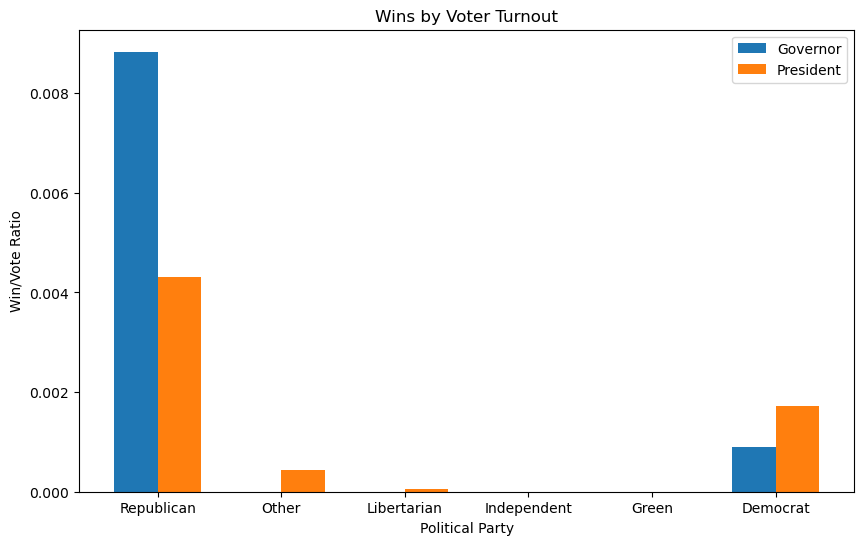

In [7]:
import pandas as pd
import matplotlib.pyplot as plt 
import statistics as stats
import numpy as np 
gcc = pd.read_csv("data/governors_county_candidate.csv")
gc = pd.read_csv("data/governors_county.csv")
pcc = pd.read_csv("data/president_county_candidate.csv")
pc = pd.read_csv("data/president_county.csv")

#aggregating, grouping, merging with Pandas, replacing variable names, sorting
party_map = {"LLC" : "Other", "NON" : "Other", "MNP" : "Other", "TM" : "Other", "DEM" : "Democrat", "REP" : "Republican", "IPD" : "Independent", "LIB" : "Libertarian", "GRN" : "Green", "PRG" : "Other", "ASP" : "Other", "PRO" : "Other", "ALI" : "Other", "APV" : "Other", "UNA" : "Other", "SWP" : "Other", "PSL" : "Other", "IND" : "Other", "CST" : "Other", "WRI" : "Other", "IAP" : "Other", "UTY" : "Other", "SEP" : "Other", "LLP" : "Other", "OTH" : "Other", "GOP" : "Republican", "BAR" : "Other", "BMP" : "Other", "BFP" : "Other"
             }
gc["governor_votes_percentage"] = gc["current_votes"]/gc["total_votes"] * 100
pc["president_votes_percentage"] = pc["current_votes"]/pc["total_votes"] * 100
gcc["party"] = gcc["party"].replace(party_map)
pcc["party"] = pcc["party"].replace(party_map)
pcc = pcc.rename(columns={"total_votes" : "votes"})
all_counties = pd.unique(
    pd.concat([gcc["county"], gc["county"], pcc["county"], pc["county"]]))
county_id_map = pd.Series(data=range(len(all_counties)), index=all_counties)
gc["county_id"] = gc["county"].map(county_id_map)
gcc["county_id"] = gcc["county"].map(county_id_map)
pc["county_id"] = pc["county"].map(county_id_map)
pcc["county_id"] = pcc["county"].map(county_id_map)
governors_agg = (gc.groupby("county_id")
                 .agg(mean_votes = ('governor_votes_percentage', 'mean'),
                      sd_votes = ('governor_votes_percentage', 'std'),
                      min_points = ('governor_votes_percentage', 'min'),
                      max_points = ('governor_votes_percentage', 'max'),
                      appearances = ('governor_votes_percentage', len)))
presidents_agg = (pc.groupby("county_id")
                  .agg(mean_votes = ('president_votes_percentage', 'mean'),
                       sd_votes = ('president_votes_percentage', 'std'),
                       min_votes = ('president_votes_percentage', 'min'),
                       max_votes = ('president_votes_percentage', 'max'),
                       appearances = ('president_votes_percentage', len)))
governors_merge = pd.merge(gcc.sort_values(by = "votes", ascending=False),
                           governors_agg,
                           on = "county_id",
                           how = "left")
presidents_merge = pd.merge(pcc.sort_values(by = "votes", ascending=False),
                            presidents_agg,
                            on = "county_id",
                            how = "left")

#wins by voter turnout grouped by party for governor and presidential elections
governors_party = (governors_merge
                   .groupby("party")[["votes", "won", "mean_votes", "county_id"]]
                   .agg({"votes" : "sum",
                         "won" : "sum",
                         "mean_votes" : "mean",
                         "county_id" : "count"
                         })
                         .reset_index()
                         .sort_values(by="won", ascending=False)
)
presidents_party = (presidents_merge
                    .groupby("party")[["votes", "won", "mean_votes", "county_id"]]
                    .agg({"votes": "sum",
                          "won" : "sum",
                          "mean_votes" : "mean",
                          "county_id" : "count"
                          })
                          .reset_index()
                          .sort_values(by="won", ascending=False)
)
governors_party["governor_vals"] = governors_party["won"]/governors_party["votes"] * 100
presidents_party["president_vals"] = presidents_party["won"]/presidents_party["votes"] * 100
party_compare = pd.merge(
    governors_party.rename(columns={
        "votes" : "gov_votes",
        "won" : "gov_won",
        "mean_votes" : "gov_mean_vote",
        "county_id" : "gov_counties"
    }),
    presidents_party.rename(columns={
        "votes" : "pres_votes",
        "won" : "pres_won",
        "mean_votes" : "pres_mean_vote",
        "county_id" : "pres_counties"
    }),
    on="party",
    how="outer"
)

party_plot = party_compare.reset_index().sort_values(by="party", ascending=False)
x = np.arange(len(party_plot["party"]))
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, party_plot["governor_vals"], width, label= "orange")
ax.bar(x + width/2, party_plot["president_vals"], width, label = "blue")
ax.set_xlabel("Political Party")
ax.set_xticks(x)
ax.set_xticklabels(party_plot["party"])
ax.set_ylabel("Win/Vote Ratio")
ax.set_title("Wins by Voter Turnout")
legend_labels = ["Governor", "President"]
ax.legend(legend_labels)
plt.show()

Based off county data, Republicans will always have higher ratio than Democrats and third parties because their election strategy relies on winning the majority of counties. In contrast, the Democratic party's election strategy relies more on winning the more few counties with major cities. Moreso in governor elections, Republicans perform better with a higher win/vote ratio than all other parties.

,party,gov_votes,gov_won,gov_mean_vote,gov_counties,governor_vals,pres_votes,pres_won,pres_mean_vote,pres_counties,president_vals,gov_percentage,republican_percentage,democrat_percentage,pres_percentage
0,Democrat,9001079,80,98.583354,1025,0.000889,82046434.0,1410.0,101.231021,4633.0,0.001719,44.079265,0,0,51.404887
1,Green,17234,0,99.117714,115,0.000000,407508.0,0.0,101.635887,3034.0,0.000000,0.084397,0,0,0.255318
2,Independent,6150,0,97.943807,3,0.000000,NaN,NaN,NaN,NaN,NaN,0.030117,0,0,NaN
3,Libertarian,581634,0,98.485841,740,0.000000,1874183.0,1.0,101.231021,4633.0,0.000053,2.848325,0,0,1.174240
4,Other,115460,0,98.762084,2237,0.000000,693232.0,3.0,101.517270,14998.0,0.000433,0.565420,0,0,0.434333
5,Republican,10698654,945,98.583354,1025,0.008833,74586880.0,3219.0,101.171069,4879.0,0.004316,52.392475,0,0,46.731222


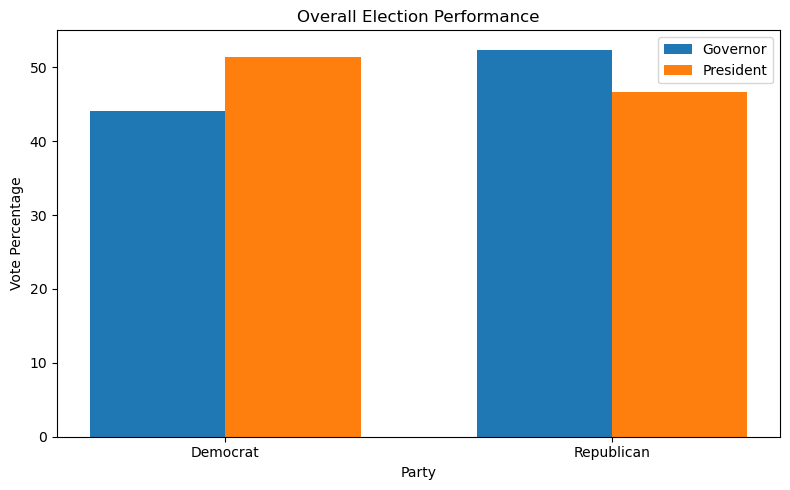

In [ ]:
#republican v democrat votes
total_gov_votes = party_compare["gov_votes"].sum()
party_compare["gov_percentage"] = party_compare["gov_votes"] / total_gov_votes * 100
republican_percentage = party_compare.loc[party_compare["party"]=="Republican", "gov_votes"].iloc[0] / total_gov_votes * 100
democrat_percentage = party_compare.loc[party_compare["party"]=="Democrat", "gov_votes"].iloc[0] / total_gov_votes * 100

party_compare["republican_percentage"] = 0
party_compare["democrat_percentage"] = 0
party_compare["gov_percentage"] = party_compare["gov_votes"] / party_compare["gov_votes"].sum() * 100
party_compare["pres_percentage"] = party_compare["pres_votes"] / party_compare["pres_votes"].sum() * 100
rep_dem_gov = party_compare[party_compare["party"].isin(["Republican", "Democrat"])]
rep_dem_pres = party_compare[party_compare["party"].isin(["Republican", "Democrat"])]
display(party_compare)

x = np.arange(len(rep_dem_gov["party"]))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(x - width/2, rep_dem_gov["gov_percentage"], width, label="orange")
ax.bar(x + width/2, rep_dem_pres["pres_percentage"], width, label="blue")
ax.set_xticks(x)
ax.set_xticklabels(rep_dem_gov["party"])
ax.set_xlabel("Party")
ax.set_ylabel("Vote Percentage")
ax.legend(legend_labels)
ax.set_title("Overall Election Performance")
plt.tight_layout()
plt.show()

For governor elections, Republicans perform better in getting more than 50% of votes. For presidential elections, Democrats perform slightly better, getting a bit more than 50% of the vote.

In [3]:
import pandas as pd
senate_county = pd.read_csv("data/senate_county.csv")
senate_county_candidate = pd.read_csv("data/senate_county_candidate.csv")
senate_state = pd.read_csv("data/senate_state.csv")

#loop 
def remove_cross_group_duplicates(series):
    assigned = set()
    result = {}
    for group, items in series.items():
        new_list = []
        for x in items:
            if x not in assigned:
                new_list.append(x)
                assigned.add(x)
        result[group] = new_list
    return pd.Series(result)

#divide counties by party
counties_by_party = (
    senate_county_candidate
        .groupby("party")["county"]
        .apply(lambda x: list(dict.fromkeys(x))) 
)
unique_counties = remove_cross_group_duplicates(counties_by_party)
counties_merge = pd.DataFrame({
    "party": unique_counties.index.tolist(),
    "counties": unique_counties.tolist(),
    "num_counties": unique_counties.apply(len).tolist()
})
#divide states by party
states_by_party = (
    senate_county_candidate
        .groupby("party")["state"]
        .apply(lambda x: list(dict.fromkeys(x)))    
)
unique_states = remove_cross_group_duplicates(states_by_party)
states_merge = pd.DataFrame({
    "party": unique_states.index.tolist(),
    "states": unique_states.tolist(),
    "num_states": unique_states.apply(len).tolist()
})
#merge counties and states data
senate_merge = pd.merge(
    counties_merge.sort_values(by="num_counties", ascending=False),
    states_merge.sort_values(by="num_states", ascending=False),
    on="party",
    how="outer"
)
#x-vals: counties and states divided by party
display(senate_merge)


,party,counties,num_counties,states,num_states
0,AKI,"[ED 10, ED 11, ED 12, ED 13, ED 14, ED 15, ED ...",40,[Alaska],1
1,APV,"[Clear Creek County, Conejos County, Costilla ...",64,[Colorado],1
2,ASP,"[Acadia Parish, Allen Parish, Ascension Parish...",64,[Louisiana],1
3,CST,"[Ada County, Bannock County, Bear Lake County,...",175,"[Idaho, North Carolina, South Carolina]",3
4,DEM,"[Sussex County, Appling County, Atkinson Count...",1498,"[Delaware, Georgia, Illinois, Iowa, Kansas, Ke...",27
5,GRN,"[Champaign County, DuPage County, Kane County,...",38,[],0
6,GRP,"[Blue Earth County, Carlton County, Hennepin C...",9,[],0
7,IND,"[Black Hawk County, Cerro Gordo County, Story ...",71,[],0
8,IPD,[New Castle County],1,[],0
9,LIB,"[Riley County, Shawnee County, Wyandotte Count...",176,[Arkansas],1


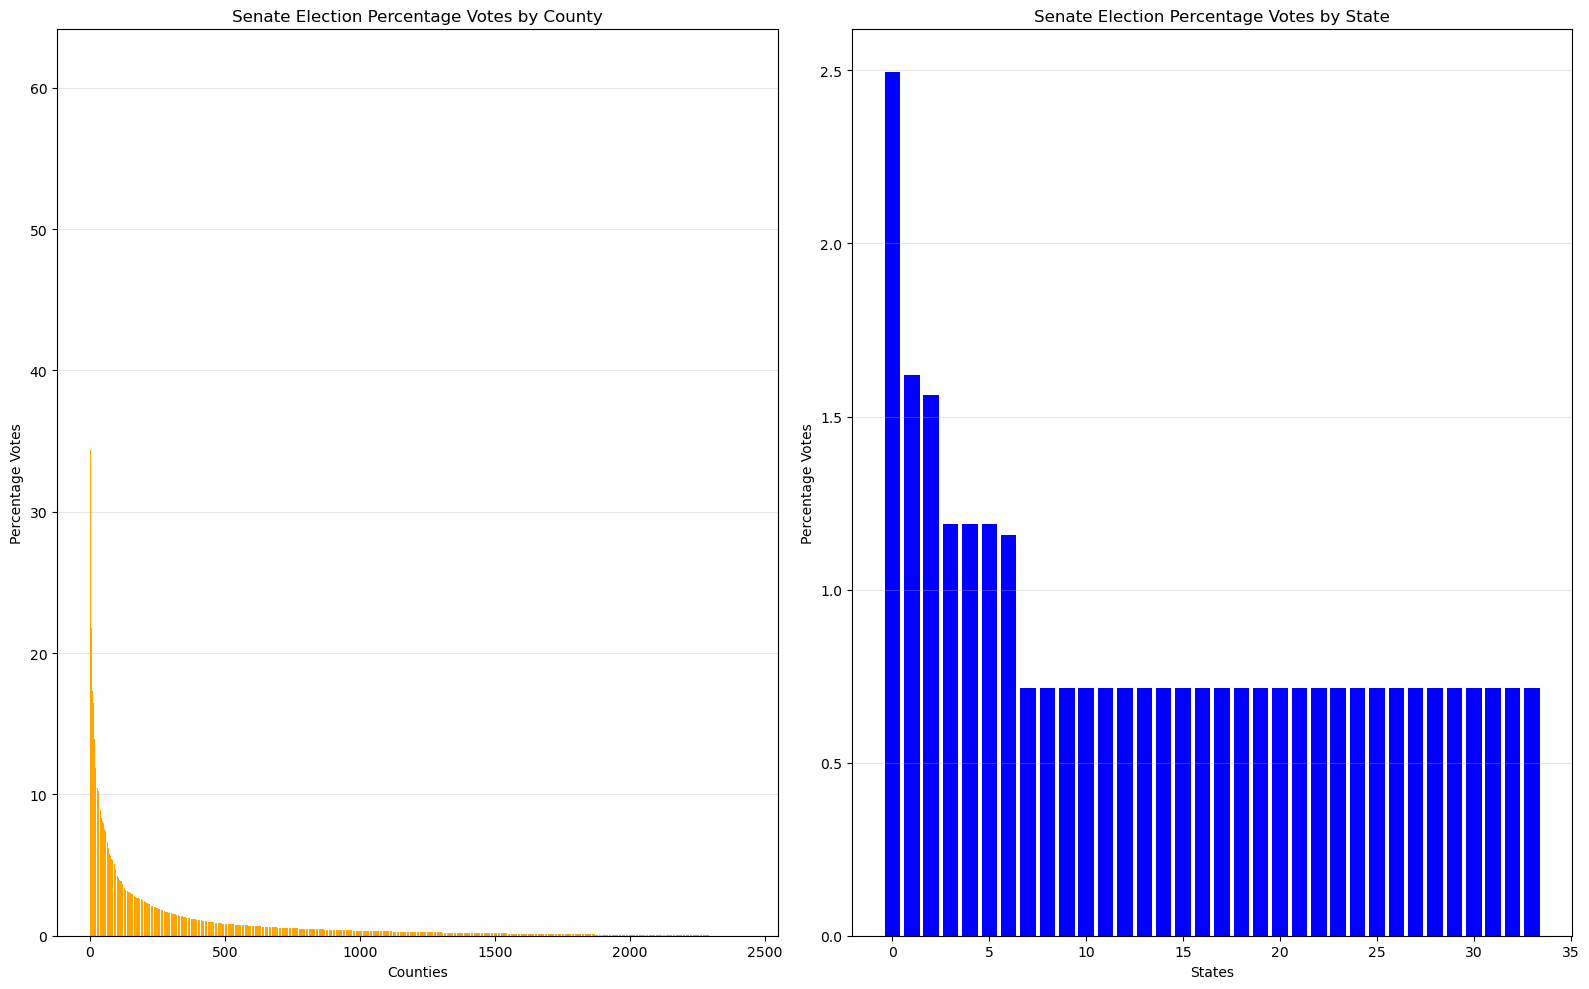

In [12]:

import pandas as pd
state_senate_merge = pd.merge(
    senate_county[["state", "county", "current_votes"]],
    senate_state.rename(columns={"total_votes" : "state_total_votes"}),
    on = "state",
    how = "left" 
    ) 
state_senate_merge["percentage_votes"] = (state_senate_merge["current_votes"] / state_senate_merge["state_total_votes"] * 100).round(4)
senate_merge_exploded = senate_merge.explode("counties") 
final_senate_merge = pd.merge(
    senate_merge_exploded,
    state_senate_merge[["state", "county", "percentage_votes"]],
    left_on="counties",
    right_on="county",
    how="left"
    ) 
final_senate_merge = final_senate_merge.drop(columns=["county", "state"])
final_senate_merge = final_senate_merge.rename(columns={"counties" : "county", "states" : "state"})

#plotting senate data
import matplotlib.pyplot as plt
import numpy as np

senate_plot = final_senate_merge.copy().reset_index(drop=True)

if senate_plot["county"].apply(lambda x: isinstance(x, list)).any():
    senate_plot = senate_plot.explode("county")
if senate_plot["state"].apply(lambda x: isinstance(x, list)).any():
    senate_plot = senate_plot.explode("state")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

county_data = senate_plot.drop_duplicates(subset=['county']).sort_values('percentage_votes', ascending=False)
county_x = np.arange(len(county_data))
ax1.bar(county_x, county_data['percentage_votes'], color='orange')
ax1.set_xlabel('Counties')
ax1.set_ylabel('Percentage Votes')
ax1.set_title('Senate Election Percentage Votes by County')
ax1.grid(axis='y', alpha=0.3)

state_data = senate_plot.groupby('state').agg({'percentage_votes': 'mean'}).reset_index().sort_values('percentage_votes', ascending=False)
state_x = np.arange(len(state_data))
ax2.bar(state_x, state_data['percentage_votes'], color='blue')
ax2.set_xlabel('States')
ax2.set_ylabel('Percentage Votes')
ax2.set_title('Senate Election Percentage Votes by State')
ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



,party,gov_votes,gov_won,gov_mean_vote,gov_counties,governor_vals,pres_votes,pres_won,pres_mean_vote,pres_counties,president_vals,gov_percentage,republican_percentage,democrat_percentage,pres_percentage
0,Democrat,9001079,80,98.583354,1025,0.000889,82046434.0,1410.0,101.231021,4633.0,0.001719,44.079265,0,0,51.404887
1,Green,17234,0,99.117714,115,0.000000,407508.0,0.0,101.635887,3034.0,0.000000,0.084397,0,0,0.255318
2,Independent,6150,0,97.943807,3,0.000000,NaN,NaN,NaN,NaN,NaN,0.030117,0,0,NaN
3,Libertarian,581634,0,98.485841,740,0.000000,1874183.0,1.0,101.231021,4633.0,0.000053,2.848325,0,0,1.174240
4,Other,115460,0,98.762084,2237,0.000000,693232.0,3.0,101.517270,14998.0,0.000433,0.565420,0,0,0.434333
5,Republican,10698654,945,98.583354,1025,0.008833,74586880.0,3219.0,101.171069,4879.0,0.004316,52.392475,0,0,46.731222


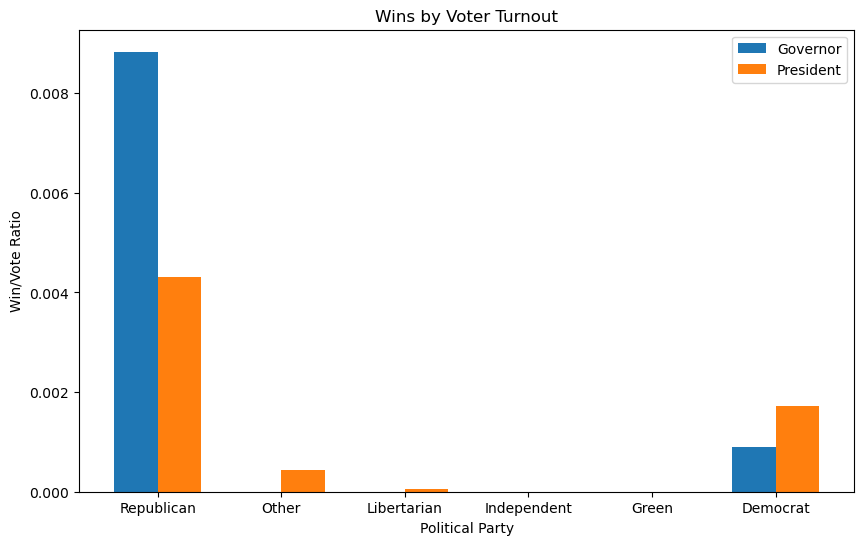

In [ ]:
#final display of tables and plots

#governor v president wins by voter turnout table
display(party_compare)
#governor v president wins by voter turnout plot
party_plot = party_compare.reset_index().sort_values(by="party", ascending=False)
x = np.arange(len(party_plot["party"]))
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, party_plot["governor_vals"], width, label= "orange")
ax.bar(x + width/2, party_plot["president_vals"], width, label = "blue")
ax.set_xlabel("Political Party")
ax.set_xticks(x)
ax.set_xticklabels(party_plot["party"])
ax.set_ylabel("Win/Vote Ratio")
ax.set_title("Wins by Voter Turnout")
legend_labels = ["Governor", "President"]
ax.legend(legend_labels)
plt.show()

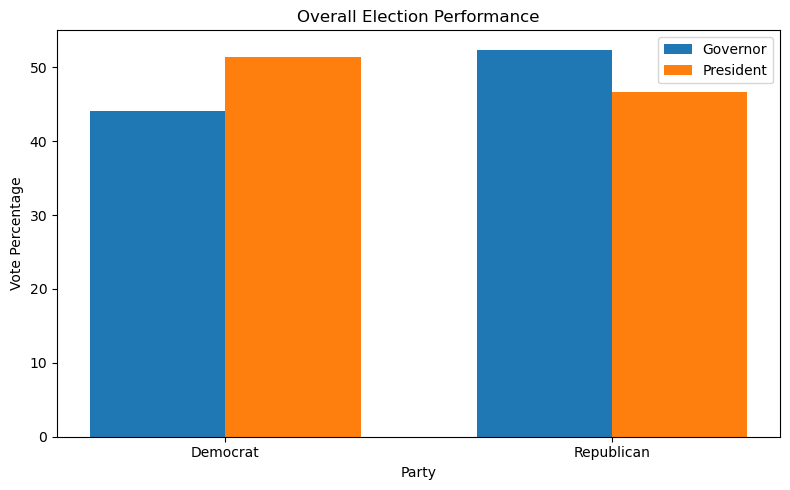

In [ ]:
#overall election performance by party plot
x = np.arange(len(rep_dem_gov["party"]))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(x - width/2, rep_dem_gov["gov_percentage"], width, label="orange")
ax.bar(x + width/2, rep_dem_pres["pres_percentage"], width, label="blue")
ax.set_xticks(x)
ax.set_xticklabels(rep_dem_gov["party"])
ax.set_xlabel("Party")
ax.set_ylabel("Vote Percentage")
ax.legend(legend_labels)
ax.set_title("Overall Election Performance")
plt.tight_layout()
plt.show()

,party,county,num_counties,state,num_states,percentage_votes
0,AKI,ED 10,40,[Alaska],1,3.1290
1,AKI,ED 11,40,[Alaska],1,2.9821
2,AKI,ED 12,40,[Alaska],1,3.1377
3,AKI,ED 13,40,[Alaska],1,2.1027
4,AKI,ED 14,40,[Alaska],1,3.2215
...,...,...,...,...,...,...
3903,REP,Coconino County,290,[],0,2.1710
3904,REP,Maricopa County,290,[],0,61.0761
3905,TAX,NaN,0,[],0,NaN
3906,UTY,NaN,0,[],0,NaN


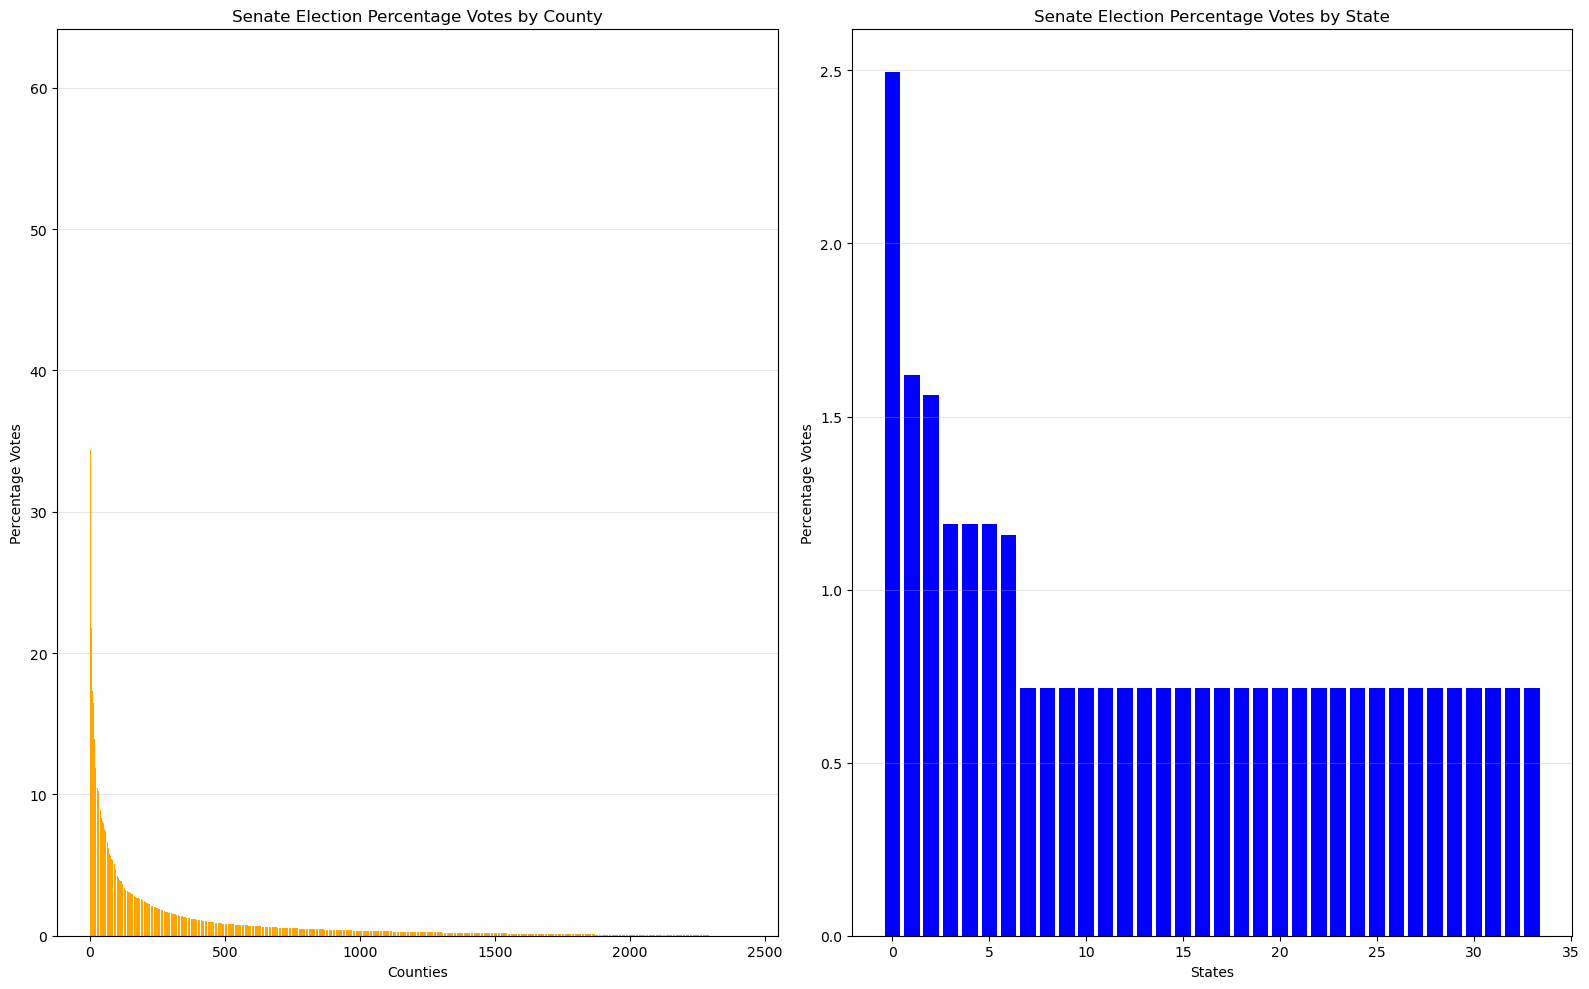

In [11]:
#senate counties and states by party table
display(final_senate_merge)

#senate election percentage votes by county and state plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

county_data = senate_plot.drop_duplicates(subset=['county']).sort_values('percentage_votes', ascending=False)
county_x = np.arange(len(county_data))
ax1.bar(county_x, county_data['percentage_votes'], color='orange')
ax1.set_xlabel('Counties')
ax1.set_ylabel('Percentage Votes')
ax1.set_title('Senate Election Percentage Votes by County')
ax1.grid(axis='y', alpha=0.3)

state_data = senate_plot.groupby('state').agg({'percentage_votes': 'mean'}).reset_index().sort_values('percentage_votes', ascending=False)
state_x = np.arange(len(state_data))
ax2.bar(state_x, state_data['percentage_votes'], color='blue')
ax2.set_xlabel('States')
ax2.set_ylabel('Percentage Votes')
ax2.set_title('Senate Election Percentage Votes by State')
ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
